# Import the required libraries

In [24]:
# Data Manipulation 
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

import keras 
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten, Conv1D, MaxPooling1D
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import layers

#NLP for text pre-processing
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# for spliting data set and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Handling imbalance data
from imblearn.over_sampling import SMOTE

# Plot the Figures Inline
%matplotlib inline


# Reading the data

In [3]:
Prod_cat_data = pd.read_csv('ecommerce.csv')

Prod_cat_data.shape


(17533, 15)

# EDA

In [4]:
Prod_cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17533 entries, 0 to 17532
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  17533 non-null  object 
 1   crawl_timestamp          17533 non-null  object 
 2   product_url              17533 non-null  object 
 3   product_name             17533 non-null  object 
 4   product_category_tree    17533 non-null  object 
 5   pid                      17533 non-null  object 
 6   retail_price             17472 non-null  float64
 7   discounted_price         17472 non-null  float64
 8   image                    17530 non-null  object 
 9   is_FK_Advantage_product  17533 non-null  bool   
 10  description              17532 non-null  object 
 11  product_rating           17533 non-null  object 
 12  overall_rating           17533 non-null  object 
 13  brand                    12301 non-null  object 
 14  product_specifications

In [5]:
Prod_cat_data['product_category_tree'].value_counts()

Clothing                       6198
Jewellery                      3531
Footwear                       1227
Mobiles & Accessories          1099
Automotive                     1012
Home Decor & Festive Needs      929
Kitchen & Dining                647
Computers                       578
Watches                         530
Baby Care                       483
Tools & Hardware                391
Toys & School Supplies          330
Pens & Stationery               313
Bags, Wallets & Belts           265
Name: product_category_tree, dtype: int64

<AxesSubplot:title={'center':'Product Category Distribution'}>

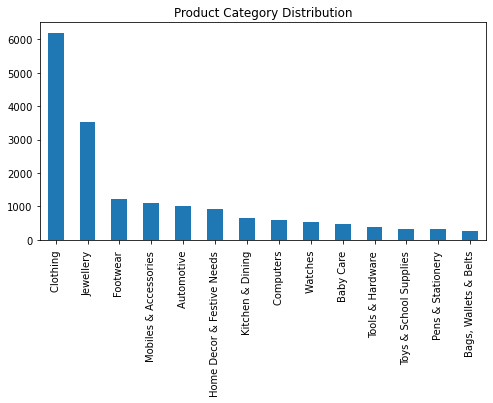

In [6]:
fig, ax = plt.subplots(figsize=[8,4], nrows=1, ncols=1)
Prod_cat_data['product_category_tree'].value_counts().plot(ax=ax, kind='bar', title='Product Category Distribution')


In [7]:
# Number of missing values in each column
missing = pd.DataFrame(Prod_cat_data.isnull().sum()).rename(columns = {0: 'missing'})

# Create a percentage of missing values
missing['percent'] = missing['missing'] / len(Prod_cat_data)

# sorting the values in descending order to see highest count on the top
missing.sort_values('percent', ascending = False)


,missing,percent
brand,5232,0.298409
retail_price,61,0.003479
discounted_price,61,0.003479
product_specifications,11,0.000627
image,3,0.000171
description,1,0.000057
uniq_id,0,0.000000
crawl_timestamp,0,0.000000
product_url,0,0.000000
product_name,0,0.000000


In [8]:
Prod_cat_data=Prod_cat_data[pd.notnull(Prod_cat_data['description'])]

Text(0.5, 1.0, 'Word distribution per bin')

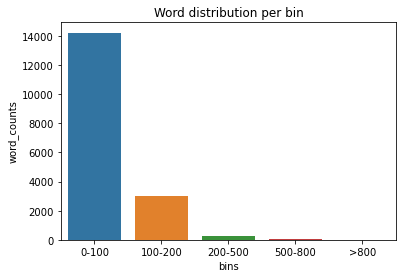

In [9]:
#Adding New column with no of words in the description before text pre processing
Prod_cat_data['no_of_words'] = Prod_cat_data.description.apply(lambda ax : len(ax.split()))

bins=[0,50,75, np.inf]
Prod_cat_data['bins']=pd.cut(Prod_cat_data.no_of_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-200', '200-500','500-800' ,'>800'])

words_distribution = Prod_cat_data.groupby('bins').size().reset_index().rename(columns={0:'word_counts'})

sns.barplot(x='bins', y='word_counts', data=words_distribution).set_title("Word distribution per bin")


In [10]:
Prod_cat_data['description'][4]

'Key Features of dilli bazaaar Bellies, Corporate Casuals, Casuals Material: Fabric Occasion: Ethnic, Casual, Party, Formal Color: Pink Heel Height: 0,Specifications of dilli bazaaar Bellies, Corporate Casuals, Casuals General Occasion Ethnic, Casual, Party, Formal Ideal For Women Shoe Details Weight 200 g (per single Shoe) - Weight of the product may vary depending on size. Heel Height 0 inch Outer Material Fabric Color Pink'

# Text Preprocessing

In [11]:
# Remove punctuation
Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'[^\w\d\s]', ' ')
# Replace whitespace between terms with a single space
Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'\s+', ' ')
# Remove leading and trailing whitespace
Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'^\s+|\s+?$', '')
# converting to lower case
Prod_cat_data['description'] = Prod_cat_data['description'].str.lower()
# Replace numbers like price values with 'numbr'
Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'\d+(\.\d+)?', 'numbr')

Prod_cat_data['description'][4]


<ipython-input-11-b4f080abbf36>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'[^\w\d\s]', ' ')
<ipython-input-11-b4f080abbf36>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'\s+', ' ')
<ipython-input-11-b4f080abbf36>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'^\s+|\s+?$', '')
<ipython-input-11-b4f080abbf36>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'\d+(\.\d+)?', 'numbr')


'key features of dilli bazaaar bellies corporate casuals casuals material fabric occasion ethnic casual party formal color pink heel height numbr specifications of dilli bazaaar bellies corporate casuals casuals general occasion ethnic casual party formal ideal for women shoe details weight numbr g per single shoe weight of the product may vary depending on size heel height numbr inch outer material fabric color pink'

In [12]:
# Removing Stopwords
stop = stopwords.words('english')
pattern = r'\b(?:{})\b'.format('|'.join(stop))
Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(pattern, '')
Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'\s+', ' ')# Removing single characters
Prod_cat_data['description'] = Prod_cat_data['description'].apply(lambda ax: " ".join(ax for ax in ax.split() if len(ax)>1)) 

Prod_cat_data['description'][4]


<ipython-input-12-a6cacc3eb10d>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(pattern, '')
<ipython-input-12-a6cacc3eb10d>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'\s+', ' ')# Removing single characters


'key features dilli bazaaar bellies corporate casuals casuals material fabric occasion ethnic casual party formal color pink heel height numbr specifications dilli bazaaar bellies corporate casuals casuals general occasion ethnic casual party formal ideal women shoe details weight numbr per single shoe weight product may vary depending size heel height numbr inch outer material fabric color pink'

# Word cloud

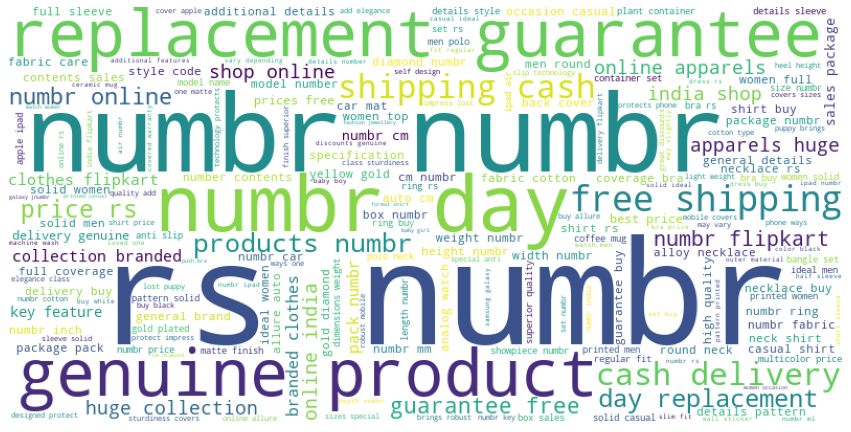

In [13]:
#Let’s plot word cloud on descriptions to get to know the words which are appearing most number of times
wordcloud = WordCloud(background_color="white", width = 800, height = 400).generate(' '.join(Prod_cat_data['description']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)    
plt.axis("off")
plt.show()


# removing domain related stopwords

In [14]:
# Removing domain-related stop words from the description

specific_stop_words = ["numbr", "rs","flipkart","buy","com","free","day","cash","replacement","guarantee","genuine","key","feature","delivery","products","product","shipping", "online","india","shop"]
Prod_cat_data['description'] = Prod_cat_data['description'].apply(lambda ax: " ".join(ax for ax in ax.split() if ax not in specific_stop_words))


# word cloud after removing domain related stop words

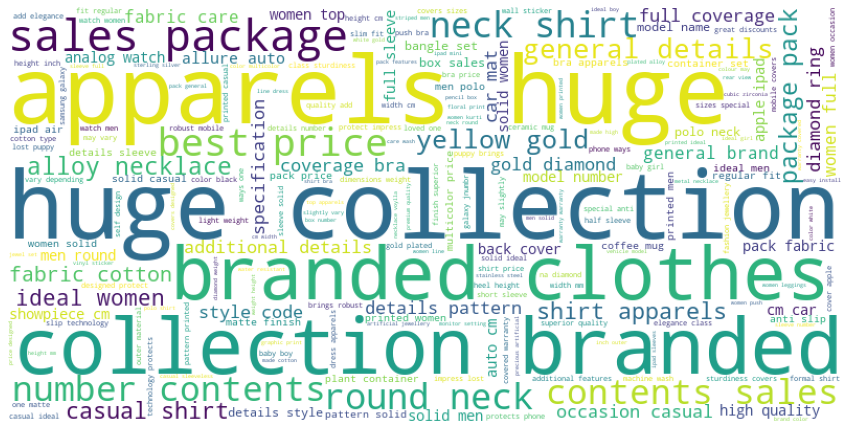

In [16]:
#Wordcloud after removing domain related stop words
wordcloud = WordCloud(background_color="white", width = 800, height = 400).generate(' '.join(Prod_cat_data['description']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)    
plt.axis("off")
plt.show()


# Text to features 

In [34]:
MAX_LENGTH= 200###############################
prod_tok = Tokenizer()
prod_tok.fit_on_texts(Prod_cat_data['description'])
clean_description = prod_tok.texts_to_sequences(Prod_cat_data['description'])
#padding
X = pad_sequences( clean_description, maxlen= max_length)


In [39]:
vocab_size = len(prod_tok.word_index) + 1#########################

# Label Encoding

In [40]:
# Label encoder for Target variable
from sklearn.preprocessing import LabelEncoder
num_class = len(np.unique(Prod_cat_data.product_category_tree.values))
y = Prod_cat_data['product_category_tree'].values
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)


# Train -test split

In [41]:
#train test split
from sklearn.model_selection import train_test_split

indepentent_features_build, indepentent_features_valid, depentent_feature_build, depentent_feature_valid = train_test_split(X, y, test_size=0.2, random_state=1) #train 80, test 20#train test split into X and y

print(indepentent_features_build.shape)
print(indepentent_features_valid.shape)
print(depentent_feature_build.shape)
print(depentent_feature_valid.shape)


(14025, 200)
(3507, 200)
(14025,)
(3507,)


# model 1

In [44]:
model_inp = Input(shape=(MAX_LENGTH, ))
object_layer = Embedding(vocab_size,100,input_length=MAX_LENGTH)(model_inp)
a = Flatten()(object_layer)
a = Dense(30)(a)
# default activation function is linear, we can make use of relu.
model_pred = Dense(num_class, activation='softmax')(a)
output = Model(inputs=[model_inp], outputs=model_pred)
output.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

output.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          1786200   
_________________________________________________________________
flatten_2 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                600030    
_________________________________________________________________
dense_5 (Dense)              (None, 14)                434       
Total params: 2,386,664
Trainable params: 2,386,664
Non-trainable params: 0
_________________________________________________________________


In [45]:
filepath="output_ANN.hdf5"
x = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#fir the model
out = output.fit([indepentent_features_build], batch_size=64, 
y=to_categorical(depentent_feature_build), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=5, callbacks=[x])


Epoch 1/5
165/165 [==============================] - 5s 27ms/step - loss: 1.4471 - acc: 0.6122 - val_loss: 0.3150 - val_acc: 0.9142

Epoch 00001: val_acc improved from -inf to 0.91417, saving model to output_ANN.hdf5
Epoch 2/5
165/165 [==============================] - 4s 24ms/step - loss: 0.1803 - acc: 0.9588 - val_loss: 0.1485 - val_acc: 0.9587

Epoch 00002: val_acc improved from 0.91417 to 0.95865, saving model to output_ANN.hdf5
Epoch 3/5
165/165 [==============================] - 4s 23ms/step - loss: 0.0535 - acc: 0.9880 - val_loss: 0.1234 - val_acc: 0.9641: 2s - loss: 0.0592 - acc: 0. - ETA: 2 - ETA: 0s - loss: 0.0550 -

Epoch 00003: val_acc improved from 0.95865 to 0.96407, saving model to output_ANN.hdf5
Epoch 4/5
165/165 [==============================] - 4s 26ms/step - loss: 0.0226 - acc: 0.9938 - val_loss: 0.1263 - val_acc: 0.9632

Epoch 00004: val_acc did not improve from 0.96407
Epoch 5/5
165/165 [==============================] - 4s 23ms/step - loss: 0.0111 - acc: 0.9968 

In [46]:
#predict
output_pred = output.predict(indepentent_features_valid)
output_pred = np.argmax(output_pred, axis=1)
accuracy_score(depentent_feature_valid, output_pred) 


0.9726261762189906

# model 2

In [47]:
model_inp = Input(shape=(MAX_LENGTH, ))

#define embedding layer
object_layer = Embedding(vocab_size,100,input_length=MAX_LENGTH)(model_inp)

#add LSTM layer
a = LSTM(60)(object_layer)

#add dense layer
a = Dense(30)(a) #default activation function is linear, we can make use of relu.

#final
model_pred = Dense(num_class, activation='softmax')(a)
output = Model(inputs=[model_inp], outputs=model_pred)

#compile
output.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
output.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 100)          1786200   
_________________________________________________________________
lstm (LSTM)                  (None, 60)                38640     
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_7 (Dense)              (None, 14)                434       
Total params: 1,827,104
Trainable params: 1,827,104
Non-trainable params: 0
_________________________________________________________________


In [48]:
filepath="output_LSTM.hdf5"

#model checkpoint
x = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#fitting
out = output.fit([indepentent_features_build], batch_size=64, y=to_categorical(depentent_feature_build), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=5, callbacks=[x]) 


Epoch 1/5
165/165 [==============================] - 29s 149ms/step - loss: 1.5657 - acc: 0.5369 - val_loss: 0.5877 - val_acc: 0.8175

Epoch 00001: val_acc improved from -inf to 0.81751, saving model to output_LSTM.hdf5
Epoch 2/5
165/165 [==============================] - 25s 152ms/step - loss: 0.4276 - acc: 0.8781 - val_loss: 0.2962 - val_acc: 0.9159

Epoch 00002: val_acc improved from 0.81751 to 0.91588, saving model to output_LSTM.hdf5
Epoch 3/5
165/165 [==============================] - 23s 142ms/step - loss: 0.1584 - acc: 0.9581 - val_loss: 0.2777 - val_acc: 0.9381

Epoch 00003: val_acc improved from 0.91588 to 0.93812, saving model to output_LSTM.hdf5
Epoch 4/5
165/165 [==============================] - 24s 146ms/step - loss: 0.0939 - acc: 0.9783 - val_loss: 0.1487 - val_acc: 0.9587

Epoch 00004: val_acc improved from 0.93812 to 0.95865, saving model to output_LSTM.hdf5
Epoch 5/5
165/165 [==============================] - 23s 140ms/step - loss: 0.0519 - acc: 0.9853 - val_loss: 0.

In [50]:
output.load_weights('output_LSTM.hdf5')

#predicting on validation data
output_pred = output.predict(indepentent_features_valid)
output_pred = np.argmax(output_pred, axis=1)

#score 
accuracy_score(depentent_feature_valid, output_pred)


0.9666381522668948

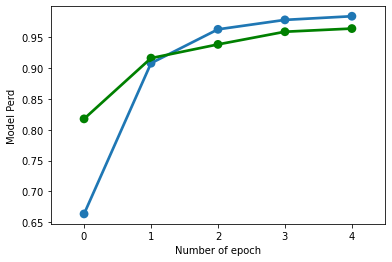

In [64]:
###############################################Number of epoch,Model Perd,Model hist

dfaccuracy = pd.DataFrame({'Number of epoch':out.epoch, 'Model hist': out.history['acc'], 'Model Perd': out.history['val_acc']})
g = sns.pointplot(x="Number of epoch", y="Model hist", data=dfaccuracy, fit_reg=False)##########Model hist
g = sns.pointplot(x="Number of epoch", y="Model Perd", data=dfaccuracy, fit_reg=False, color='Green')##########Model Perd

# model 3

In [65]:
model_inp = Input(shape=(MAX_LENGTH, ))

# define the layer
object_layer = Embedding(vocab_size,100,input_length=MAX_LENGTH)(model_inp)

#conv layer
a = Conv1D(60, 10)(object_layer) #default activation function is linear, we can make use of relu.

#add pooling layer
a = MaxPooling1D(pool_size=2)(a)
#add LSTM
a = LSTM(60)(a)
a = Dense(30)(a)

#final layer
model_pred = Dense(num_class, activation='softmax')(a)
output = Model(inputs=[model_inp], outputs=model_pred)

#compile
output.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
output.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 100)          1786200   
_________________________________________________________________
conv1d (Conv1D)              (None, 191, 60)           60060     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 95, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_8 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_9 (Dense)              (None, 14)                434 

In [66]:
filepath="output_CNN.hdf5"
x = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
out = output.fit([indepentent_features_build], batch_size=64, y=to_categorical(depentent_feature_build), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=5, callbacks=[x])


Epoch 1/5
165/165 [==============================] - 27s 146ms/step - loss: 1.3419 - acc: 0.6063 - val_loss: 0.3929 - val_acc: 0.9005

Epoch 00001: val_acc improved from -inf to 0.90048, saving model to output_CNN.hdf5
Epoch 2/5
165/165 [==============================] - 25s 151ms/step - loss: 0.2522 - acc: 0.9336 - val_loss: 0.2040 - val_acc: 0.9398

Epoch 00002: val_acc improved from 0.90048 to 0.93983, saving model to output_CNN.hdf5
Epoch 3/5
165/165 [==============================] - 25s 149ms/step - loss: 0.0899 - acc: 0.9745 - val_loss: 0.1688 - val_acc: 0.9589

Epoch 00003: val_acc improved from 0.93983 to 0.95894, saving model to output_CNN.hdf5
Epoch 4/5
165/165 [==============================] - 24s 144ms/step - loss: 0.0445 - acc: 0.9889 - val_loss: 0.1469 - val_acc: 0.9644

Epoch 00004: val_acc improved from 0.95894 to 0.96436, saving model to output_CNN.hdf5
Epoch 5/5
165/165 [==============================] - 24s 146ms/step - loss: 0.0256 - acc: 0.9931 - val_loss: 0.1580

In [67]:
output.load_weights('output_CNN.hdf5')
predicted = output.predict(indepentent_features_valid)


In [68]:
predicted = np.argmax(predicted, axis=1)
accuracy_score(depentent_feature_valid, predicted)


0.9683490162532079

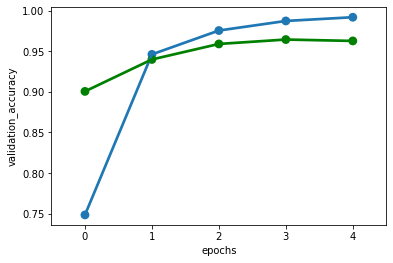

In [69]:
dfaccuracy = pd.DataFrame({'epochs':out.epoch, 'accuracy': out.history['acc'], 'validation_accuracy': out.history['val_acc']})

#plot
g = sns.pointplot(x="epochs", y="accuracy", data=dfaccuracy, fit_reg=False)

#plot test accuracy
g = sns.pointplot(x="epochs", y="validation_accuracy", data=dfaccuracy, fit_reg=False, color='green')


# model with Hyperparameters tuning


In [73]:
#Below are the steps for Hyperparameters tuning include.
def build(num_filters, kernel_size, vocab_size, embedding_dim, maxlength):
    output = Sequential()

    #add embeddings
    output.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlength))
    output.add(layers.Conv1D(num_filters, kernel_size)) #default activation function is linear, we can make use of relu.
    output.add(layers.GlobalMaxPooling1D())
    output.add(layers.Dense(20)) 
#default activation function is linear, we can make use of relu.
    output.add(layers.Dense(num_class, activation='softmax'))
    output.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
    return output########################output


In [74]:
#Running the Randomized Search:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

#build the models with parameters
output = KerasClassifier(build_fn=build,
                            epochs=5, batch_size=64,
                            verbose=False)
out = RandomizedSearchCV(estimator=output, param_distributions={'num_filters': [30, 60, 100],'kernel_size': [4, 6, 8],'embedding_dim': [40],'vocab_size': [17862],
 'maxlength': [180]},cv=4, verbose=1, n_iter=5)
out_result = out.fit(indepentent_features_build, depentent_feature_build)


Fitting 4 folds for each of 5 candidates, totalling 20 fits


In [75]:
#Find the best parameters of the model:

# Evaluate testing set
test_accuracy = out.score(indepentent_features_valid, depentent_feature_valid)
print(out_result.best_params_)


{'vocab_size': 17862, 'num_filters': 100, 'maxlength': 180, 'kernel_size': 8, 'embedding_dim': 40}


In [76]:
print(out_result.best_score_)

0.9770408421754837


In [77]:
print(test_accuracy)###############

0.9837467670440674